In [82]:
from pyspark.ml.clustering import KMeans, KMeansModel
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StandardScaler, PCA, MinMaxScaler,Normalizer, PCAModel
import random
from pyspark.ml.functions import vector_to_array
import matplotlib.pyplot as plt
import pandas as pd
import json, pickle
from math import inf, sqrt

In [2]:
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession\
        .builder\
        .appName("KMeansCluster")\
        .config("setMaster", "local[2]")\
        .getOrCreate()

In [4]:
temp_path = "Saved_S3/"

In [5]:
path = "dataset_construction/dataset/"

In [6]:
filenames = os.listdir(path)

In [7]:
df_final = spark.read.option("multiline", "true").json(path+filenames[0])

In [8]:
for filename in filenames[1:]:
    full_path = path+filename
    df = spark.read.option("multiline", "true").json(full_path)
    df_final = df_final.union(df)

In [9]:
df = df_final.drop('id','duration_ms','time_signature')

In [49]:
ids_of_songs = df_final.select('id')

In [10]:
df.count()

2262190

In [11]:
len(df.columns)

11

In [12]:
# acousticness : A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high 
#confidence the track is acoustic.

#danceability : Danceability describes how suitable a track is for dancing based on a combination of musical elements 
#including tempo, rhythm stability, beat strength, and overall regularity. 
#A value of 0.0 is least danceable and 1.0 is most danceable.

# energy : Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. 
# Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.

# instrumentalness : Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental 
# in this context. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.

# key : The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.

# liveness : Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

# loudness :  Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db.

# mode : Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

# speechiness : Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. 

# tempo : The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

# valence : A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track.

df.printSchema() 

root
 |-- acousticness: double (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- key: long (nullable = true)
 |-- liveness: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: long (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- valence: double (nullable = true)



In [13]:
df.show(2)

+------------+------------+------+----------------+---+--------+--------+----+-----------+-------+-------+
|acousticness|danceability|energy|instrumentalness|key|liveness|loudness|mode|speechiness|  tempo|valence|
+------------+------------+------+----------------+---+--------+--------+----+-----------+-------+-------+
|      0.0184|       0.533| 0.699|         0.00511|  0|   0.163|  -7.782|   1|     0.0399|143.426|   0.62|
|       0.563|       0.609| 0.606|           0.576|  9|     0.1|  -7.559|   0|     0.0583| 83.986|  0.362|
+------------+------------+------+----------------+---+--------+--------+----+-----------+-------+-------+
only showing top 2 rows



In [14]:
dataset = df.rdd.map(lambda x:(Vectors.dense(x), 0)).toDF(["features"])

In [16]:
dataset = dataset.drop('_2')

In [17]:
scale_std = StandardScaler(inputCol='features',outputCol='standardized_std')

In [18]:
data_scale_std = scale_std.fit(dataset)

In [19]:
data_scale_std = data_scale_std.transform(dataset)

In [20]:
data_scale_std.show(2)

+--------------------+--------------------+
|            features|    standardized_std|
+--------------------+--------------------+
|[0.0184,0.533,0.6...|[0.05191944023025...|
|[0.563,0.609,0.60...|[1.58862200269756...|
+--------------------+--------------------+
only showing top 2 rows



In [21]:
pca = PCA(k=11,inputCol="standardized_std",outputCol="pca_output")

In [22]:
pca_model_components_fit = pca.fit(data_scale_std)

In [23]:
pca_model_components = pca_model_components_fit.transform(data_scale_std)

In [24]:
variances = pca_model_components_fit.explainedVariance

In [25]:
store_cumulative_score = []
cum_sum = 0
desired_no_components = 0
counter=0
for i in variances:
    counter+=1
    cum_sum += i
    if cum_sum >= 0.8 and (desired_no_components == 0):
        desired_no_components = counter
    store_cumulative_score.append(cum_sum)

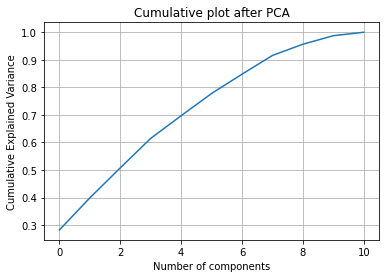

In [26]:
plt.plot(store_cumulative_score)
plt.ylabel('Cumulative Explained Variance')
plt.xlabel('Number of components')
plt.title('Cumulative plot after PCA')
plt.grid()

In [27]:
print("Number of components selected variance : "+str(desired_no_components))

Number of components selected variance : 7


In [28]:
# Now do PCA with desired number of components
pca = PCA(k=desired_no_components,inputCol="features",outputCol="pca_output")

In [29]:
pca_model = pca.fit(dataset)

In [30]:
modelPath = temp_path + "/pca-model"

In [31]:
pca_model.save(modelPath)

In [32]:
loadedModel = PCAModel.load(modelPath)

In [33]:
# Check if we have have the right model
loadedModel.pc == pca_model.pc

True

In [34]:
pca_dataset = pca_model.transform(dataset)

In [35]:
pca_dataset.show(2)

+--------------------+--------------------+
|            features|          pca_output|
+--------------------+--------------------+
|[0.0184,0.533,0.6...|[142.993122049265...|
|[0.563,0.609,0.60...|[83.6187471183277...|
+--------------------+--------------------+
only showing top 2 rows



In [37]:
for j in range(2,11):
    kmeans = KMeans(featuresCol='pca_output',k=j).setSeed(random.randint(10,100))
    K_means_model = kmeans.fit(pca_dataset)
    predictions = K_means_model.transform(pca_dataset)
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    print("Silhouette with squared euclidean distance, K : " + str(silhouette)+" "+str(j))

Silhouette with squared euclidean distance, K : 0.6787138206440881 2
Silhouette with squared euclidean distance, K : 0.6989210280470041 3
Silhouette with squared euclidean distance, K : 0.6004689804796427 4
Silhouette with squared euclidean distance, K : 0.5867034301886304 5
Silhouette with squared euclidean distance, K : 0.5253868265575492 6
Silhouette with squared euclidean distance, K : 0.5153210369479297 7
Silhouette with squared euclidean distance, K : 0.508603645940609 8
Silhouette with squared euclidean distance, K : 0.5103744620972183 9
Silhouette with squared euclidean distance, K : 0.4661230031801494 10


In [38]:
kmeans = KMeans(featuresCol='pca_output',k=7).setSeed(random.randint(10,100))

In [39]:
K_means_model = kmeans.fit(pca_dataset)

In [40]:
predictions = K_means_model.transform(pca_dataset)

In [41]:
evaluator = ClusteringEvaluator()

In [42]:
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance : " + str(silhouette))

Silhouette with squared euclidean distance : 0.5195549671404569


In [43]:
modelPath_kmeans = temp_path + "/kmeans-model"

In [44]:
K_means_model.save(modelPath_kmeans)

In [45]:
load_kmeans_model = KMeansModel.load(modelPath_kmeans)

In [46]:
# Checking if we have the right centers
centers = load_kmeans_model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[107.22095172  13.88609519  -5.61205912   0.71111087  -0.22198325
   0.6533063   -0.64056935]
[143.27848929  14.44075803  -5.60475641   0.70769733  -0.18836759
   0.62618328  -0.57393906]
[125.12262201  13.79813713  -5.65089599   0.66156886  -0.15010067
   0.68150013  -0.62628421]
[168.67545668  15.16123442  -5.60528997   0.70835058  -0.20888915
   0.59840914  -0.57389358]
[191.97899524  16.18230746  -5.63628117   0.75260153  -0.25438885
   0.55805303  -0.59638668]
[72.36911081 17.844295   -5.62093489  0.72066676 -0.16344237  0.5523817
 -0.53371017]
[90.15726087 12.86228506 -5.62978702  0.70368198 -0.23529283  0.63912888
 -0.61074817]


In [57]:
predictions = predictions.select('prediction').toPandas()

In [58]:
ids_of_songs = ids_of_songs.toPandas()

In [73]:
predictions = predictions.rename(columns={'prediction':'cluster_id'})

In [74]:
final_df = pd.concat([ids_of_songs,predictions],axis=1)

In [75]:
final_df

,id,cluster_id
0,4ewx6y0PsZj7vY5eMqmU19,1
1,1rRUPou2hzjQ1DDJoBhLPp,6
2,5PSFr1lLBMDOTf64Wfbz2w,4
3,1IwuYbRJsKSg9ONW6J2p9A,6
4,4c2k8o224i1em0fLTVUd7k,4
...,...,...
2262185,59ocQv18mhv8SlLDB7pUU3,3
2262186,5SrGylgtB1zUpXM8AVdUpc,5
2262187,3lvBMabCYCgvuaNDMCCjtE,5
2262188,68hF5EW9EAwUlIMwGuZ60G,2


In [76]:
final = final_df.to_json(orient='index')

In [79]:
final = json.loads(final)

In [80]:
load_dict = {}
for f in final: 
    load_dict[final[f]["id"]] = final[f]["cluster_id"]

In [83]:
with open('final_results.pkl', 'wb') as f:
    pickle.dump(load_dict, f)

In [84]:
with open('final_results.pkl', 'rb') as f:
    data = pickle.load(f)